# Module 7 Exercise


In [ ]:
!pip install qiskit

#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.7/129.7 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 68.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 12.6 MB/s eta 0:00:00
  Created wheel for qiskit: filename=qiskit-0.42.1-py3-n

# 2.1 Grover's Search

## Edit the oracle below so that the searched bitstring is not 111, but 101 and 110 together.

Follow https://learn.qiskit.org/course/ch-algorithms/grovers-algorithm#3qubits
for additional aid.

Defining the oracle for the bitstring 111

In [ ]:
qc = QuantumCircuit(3)

qc.h(0)
qc.ccx(1,2,0)
qc.h(0)

oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"

qc.draw()

┌───┐┌───┐┌───┐
q_0: ┤ H ├┤ X ├┤ H ├
     └───┘└─┬─┘└───┘
q_1: ───────■───────
            │       
q_2: ───────■───────

Create a function that applies H gates to the qubits before applying the oracle.

In [ ]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

Define the diffuser circuit

In [ ]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

Define the complete Grover circuit by combing the oracle and the diffuser.

In [ ]:
n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw()

┌───┐┌─────────────┐┌────────┐ ░ ┌─┐      
   q_0: ┤ H ├┤0            ├┤0       ├─░─┤M├──────
        ├───┤│             ││        │ ░ └╥┘┌─┐   
   q_1: ┤ H ├┤1 U$_\omega$ ├┤1 U$_s$ ├─░──╫─┤M├───
        ├───┤│             ││        │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├┤2            ├┤2       ├─░──╫──╫─┤M├
        └───┘└─────────────┘└────────┘ ░  ║  ║ └╥┘
meas: 3/══════════════════════════════════╩══╩══╩═
                                          0  1  2

{'000': 16, '010': 31, '001': 36, '101': 25, '100': 42, '110': 40, '011': 32, '111': 802}


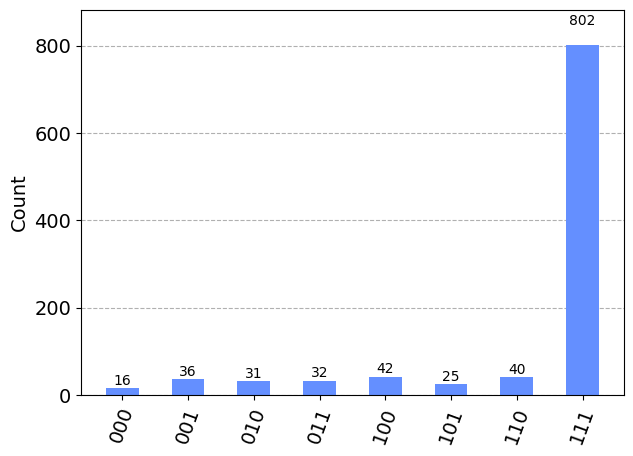

In [ ]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = backend_sim.run(transpile(grover_circuit, backend_sim), shots=1024)

# Grab the results from the job.
result_sim = job_sim.result()

counts = result_sim.get_counts(grover_circuit)
print(counts)

plot_histogram(counts)

# Exercise

Redefine the oracle for bitsrings 101 and 110 together.

In [ ]:
#[you code here]

The diffuser fuction could be reused to define a new circuit 

In [ ]:
n = 3
grover_circuit_ex = QuantumCircuit(n)
grover_circuit_ex = initialize_s(grover_circuit, [0,1,2])
# insert your code for the oracle here
grover_circuit_ex.append(diffuser(n), [0,1,2])
grover_circuit_ex.measure_all()
grover_circuit_ex.draw()

Run the new circuit using the Aer simulator

In [ ]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim_ex = backend_sim.run(transpile(grover_circuit_ex, backend_sim), shots=1024)

# Grab the results from the job.
result_sim_ex = job_sim_ex.result()

counts = result_sim_ex.get_counts(grover_circuit_ex)
print(counts)

plot_histogram(counts)

# 2.2 Optional Advanced Exercise - QFT

## What is Fourier Transform ?

Fourier Transform (FT) is a mathematical transformation of a function. If a function (or data) represents variation of something in time, its Fourier transformation represent a corresponding function (or data) that represents distribution of frequency.

For most numerical, and computing situation one uses FT on a discrete data, called Discrete Fourier Transformation (DFT).

If we have a sequence of N values, say $X_0$, $X_1$, X$_2$, ... $X_{N-1}$, the DFT of this 'vector'
of values is a vector $Y = {Y_0, Y_1, Y_2, ..., Y_{N-1}}$, where

$$
Y_k = \frac{1}{\sqrt{N}}\sum_{n=0}^{N-1} X_n e^{\frac{2\pi i}{N} n k} \quad\text{where } k=0, 1, ... N-1
$$

The above is summed over the number of values $N$, and the division with $\frac{1}{\sqrt{N}}$ is for normalisation. Written explicitly, we have

$$
Y_k = \frac{1}{\sqrt{N}}\left( X_0 + X_1 e^{\frac{2\pi i}{N} k} + X_2 e^{\frac{2\pi i}{N} 2k} + X_3 e^{\frac{2\pi i}{N} 3k} + \dots X_{N-1} e^{\frac{2\pi i}{N} (N-1) k}\right)
$$

FT is widely used in signal and image processing, to analyse data. Following video from 3b1b YouTube channel gives a visual and colloquial introduction to Fourier Transform (Please do watch it) -

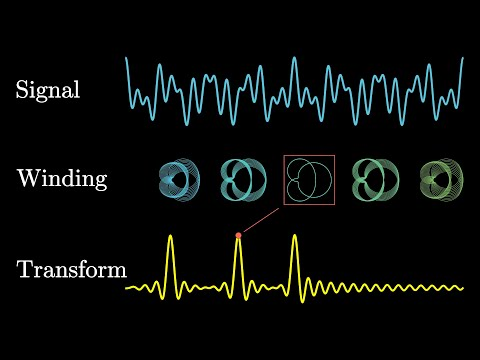

In [ ]:
from IPython.display import YouTubeVideo
vid = YouTubeVideo("spUNpyF58BY", width=1280, height=720); display(vid)

In [ ]:
# Imports
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.tools.monitor import job_monitor


# Quantum Fourier Transform

The Quantum Fourier Transform, in simple terms is essentially Discrete Fourier transform of a Quantum State through it's coefficient.

Imagine a basis of states $\{|l\rangle , l=0, 1, 2, ... N-1\}$, then any quantum state is defined by it's 'composition' on this basis -

$$
|X\rangle = x_0|0\rangle + x_1|1\rangle + x_1|1\rangle ... + x_{N-1}|N-1\rangle 
$$

The QFT of state $|X\rangle$ is state $|Y\rangle$, where

$$
|Y\rangle = y_0|0\rangle + y_1|1\rangle + y_1|1\rangle ... + y_{N-1}|N-1\rangle 
$$

and $y_k$ is defined through FT of $x_n$, i.e., 

$$
y_k = \frac{1}{\sqrt{2}} \left(x_0 + x_1 e^{\frac{2\pi i}{N} k} + x_2 e^{\frac{2\pi i}{N} 2k} + x_3 e^{\frac{2\pi i}{N} 3k} + \dots x_{N-1} e^{\frac{2\pi i}{N} (N-1) k}\right)
$$


Please see the Qiskit tutorial on Quantum Fourier transform, Read until section 2 -

https://learn.qiskit.org/course/ch-algorithms/quantum-fourier-transform

##Self run 1 qubit circuit





For a system described by a single qubit, any state can be represented as

$$
|X\rangle = x_0 |0\rangle + x_1 |1\rangle
$$

So in order to compute QFT of $|X\rangle$, we compute DFT of $\{x_0, x_1\}$, with number of values $N=2$.

$$
y_0 = \frac{1}{\sqrt{2}}\left( x_0 + x_1 e^{\frac{2\pi i}{2} 0}\right) = \frac{1}{\sqrt{2}}(x_0 + x_1), 
\\
y_1 = \frac{1}{\sqrt{2}}\left(x_0 + x_1 e^{\frac{2\pi i}{2}}\right) = \frac{1}{\sqrt{2}}(x_0 - x_1)
$$

as $e^{\pi i} = -1$

Thus, the QFT of single qubit $|X\rangle$ is -
$$
|Y\rangle = \frac{1}{\sqrt{2}}(x_0 + x_1)|0\rangle + \frac{1}{\sqrt{2}}(x_0 - x_1)|1\rangle
$$
This state can be re-expressed  as column vector as follows -

$$
|Y\rangle = \frac{1}{\sqrt{2}}
\begin{pmatrix}
  x_0 + x_1
  \\
  x_0 - x_1
  \end{pmatrix}
  = \frac{1}{\sqrt{2}}\begin{pmatrix}
  1 & 1
  \\
  1 & -1
  \end{pmatrix}
  \begin{pmatrix}
  x_0
  \\
  x_1
  \end{pmatrix}
$$

Notice that the last column $\begin{pmatrix} x_0 \\ x_1\end{pmatrix}$ is vector representation of the original state $|X\rangle$, and the $2\times 2$ matrix is actually the matrix representation of the Hadamard Operation, or Hadamard Gate.

$$
H = \frac{1}{\sqrt{2}}\begin{pmatrix}
  1 & 1
  \\
  1 & -1
  \end{pmatrix}
$$

So the QFT of a single qubit can be computed simplify by applying a Hadamard gate.

## Construct 3 qbit qft circuit

The figure below shows how a circuit for implementing QFT for three qubit system looks like.

The circuit for 3 qubits has controlled rotation gates between qubits.
You can try going through 3, 4 and 5 qubits to get a sense of how to build a QFT circuit for an arbitrary number of qubits

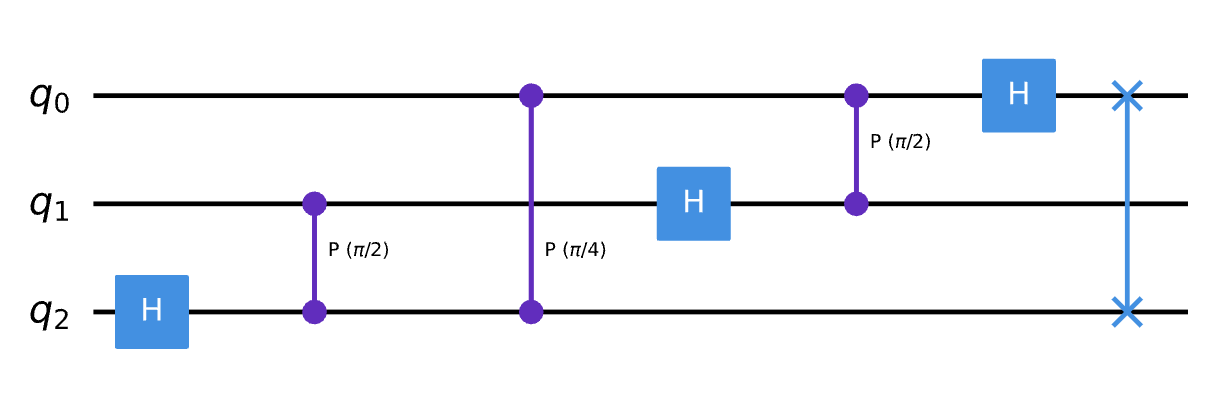

This is the circuit we're required to implement

In [ ]:
#Hadamard on q2 followed by corresponding rotation operations on q2
pi = np.pi
QFT_cirq = QuantumCircuit(3)
QFT_cirq.h(2)
QFT_cirq.cp(pi/2, 1, 2) # CROT from qubit 1 to qubit 2

QFT_cirq.cp(pi/4, 0, 2) # CROT from qubit 0 to qubit 2
QFT_cirq.draw()

q_0: ───────────────■───────
                    │       
q_1: ──────■────────┼───────
     ┌───┐ │P(π/2)  │P(π/4) 
q_2: ┤ H ├─■────────■───────
     └───┘

In [ ]:
#Hadamard on q1 followed by corresponding rotation operations on q1

#Write your code here

In [ ]:
#Hadamard on q0 

#Write your code here

In [ ]:
#Swap operations as final step of the process

#Write your code here

In [ ]:
# Run your code on simulator of choice

#Write your code here

In [ ]:
#Display results on plot

#Write your code here

Use inbuilt QFT cicuit class defined in section 8 to build the circuit for 3 qubits and simulate it

https://qiskit.org/documentation/stable/0.24/stubs/qiskit.circuit.library.QFT.html

Invert the output of the first circuit using the same circuit class by changing the inverse flag as "True"  to show that we get the same input vector